In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image
import os
import glob
from tqdm import tqdm
import shutil
import matplotlib.pyplot as plt
import numpy as np
from collections import OrderedDict
from sklearn.model_selection import train_test_split

In [2]:
print("Preparing data structure with Train/Validation split...")

# 1.Define Correct Source and Destination Paths
SOURCE_DATA_DIR = '/kaggle/input/xview2/train'
KAGGLE_WORKING_DIR = '/kaggle/working/dataset'
TRAIN_DIR = os.path.join(KAGGLE_WORKING_DIR, 'train')
VAL_DIR = os.path.join(KAGGLE_WORKING_DIR, 'validation')

# 2.Create the new folder structure
os.makedirs(os.path.join(TRAIN_DIR, 'pre'), exist_ok=True)
os.makedirs(os.path.join(TRAIN_DIR, 'post'), exist_ok=True)
os.makedirs(os.path.join(TRAIN_DIR, 'masks'), exist_ok=True)
os.makedirs(os.path.join(VAL_DIR, 'pre'), exist_ok=True)
os.makedirs(os.path.join(VAL_DIR, 'post'), exist_ok=True)
os.makedirs(os.path.join(VAL_DIR, 'masks'), exist_ok=True)

# 3.Find and verify matched sets of images and masks
print("Finding and verifying matched image-mask pairs...")
all_pre_images_initial = sorted(glob.glob(os.path.join(SOURCE_DATA_DIR, 'images', '*_pre_disaster.png')))

matched_pre_images = []
matched_post_images = []
matched_masks = []

images_dir = os.path.join(SOURCE_DATA_DIR, 'images')
masks_dir = os.path.join(SOURCE_DATA_DIR, 'masks')

for pre_path in tqdm(all_pre_images_initial):
    base_name = os.path.basename(pre_path).replace('_pre_disaster.png', '')
    
    # Correctly construct the paths based on the confirmed naming convention
    post_filename = f"{base_name}_post_disaster.png"
    post_path = os.path.join(images_dir, post_filename)
    mask_path = os.path.join(masks_dir, post_filename)
    
    if os.path.exists(post_path) and os.path.exists(mask_path):
        matched_pre_images.append(pre_path)
        matched_post_images.append(post_path)
        matched_masks.append(mask_path)

print(f"Found {len(matched_pre_images)} complete sets of images and masks.")

# 4.Split data into training and validation sets
if not matched_pre_images:
    raise FileNotFoundError("Could not find any matched image sets. The dataset may be incomplete or named differently.")
    
indices = list(range(len(matched_pre_images)))
train_indices, val_indices = train_test_split(indices, test_size=0.2, random_state=42)

# 5.Function to copy files
def copy_files(indices, destination_dir):
    for i in tqdm(indices, desc=f"Copying to {os.path.basename(destination_dir)}"):
        shutil.copy(matched_pre_images[i], os.path.join(destination_dir, 'pre'))
        shutil.copy(matched_post_images[i], os.path.join(destination_dir, 'post'))
        shutil.copy(matched_masks[i], os.path.join(destination_dir, 'masks'))

copy_files(train_indices, TRAIN_DIR)
copy_files(val_indices, VAL_DIR)

print("Data preparation complete!")

Preparing data structure with Train/Validation split...
Finding and verifying matched image-mask pairs...


100%|██████████| 2799/2799 [00:05<00:00, 475.72it/s]


Found 2799 complete sets of images and masks.


Copying to validation: 100%|██████████| 560/560 [00:21<00:00, 25.53it/s]

Data preparation complete!


In [3]:
class SiamUnet(nn.Module):
    def __init__(self, in_channels=3, out_channels_s=2, out_channels_c=5, init_features=16):
        super(SiamUnet, self).__init__()
        features = init_features

        # Encoder
        self.encoder1 = SiamUnet._block(in_channels, features, name="enc1")
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.encoder2 = SiamUnet._block(features, features * 2, name="enc2")
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.encoder3 = SiamUnet._block(features * 2, features * 4, name="enc3")
        self.pool3 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.encoder4 = SiamUnet._block(features * 4, features * 8, name="enc4")
        self.pool4 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.bottleneck = SiamUnet._block(features * 8, features * 16, name="bottleneck")

        # Decoder
        self.upconv4 = nn.ConvTranspose2d(features * 16, features * 8, kernel_size=2, stride=2)
        self.decoder4 = SiamUnet._block((features * 8) * 2, features * 8, name="dec4")
        self.upconv3 = nn.ConvTranspose2d(features * 8, features * 4, kernel_size=2, stride=2)
        self.decoder3 = SiamUnet._block((features * 4) * 2, features * 4, name="dec3")
        self.upconv2 = nn.ConvTranspose2d(features * 4, features * 2, kernel_size=2, stride=2)
        self.decoder2 = SiamUnet._block((features * 2) * 2, features * 2, name="dec2")
        self.upconv1 = nn.ConvTranspose2d(features * 2, features, kernel_size=2, stride=2)
        self.decoder1 = SiamUnet._block(features * 2, features, name="dec1")
        self.conv_s = nn.Conv2d(in_channels=features, out_channels=out_channels_s, kernel_size=1)
        
        # Change Detection Branch
        self.upconv4_c = nn.ConvTranspose2d(features * 16, features * 8, kernel_size=2, stride=2)
        self.conv4_c = SiamUnet._block(features * 16, features * 16, name="conv4_c")
        self.upconv3_c = nn.ConvTranspose2d(features * 16, features * 4, kernel_size=2, stride=2)
        self.conv3_c = SiamUnet._block(features * 8, features * 8, name="conv3_c")
        self.upconv2_c = nn.ConvTranspose2d(features * 8, features * 2, kernel_size=2, stride=2)
        self.conv2_c = SiamUnet._block(features * 4, features * 4, name="conv2_c")
        self.upconv1_c = nn.ConvTranspose2d(features * 4, features, kernel_size=2, stride=2)
        self.conv1_c = SiamUnet._block(features * 2, features * 2, name="conv1_c")
        self.conv_c = nn.Conv2d(in_channels=features * 2, out_channels=out_channels_c, kernel_size=1)
        
    def forward(self, x1, x2):
        # Branch 1 (pre-disaster)
        enc1_1 = self.encoder1(x1)
        enc2_1 = self.encoder2(self.pool1(enc1_1))
        enc3_1 = self.encoder3(self.pool2(enc2_1))
        enc4_1 = self.encoder4(self.pool3(enc3_1))
        bottleneck_1 = self.bottleneck(self.pool4(enc4_1))

        dec4_1 = self.upconv4(bottleneck_1)
        dec4_1 = torch.cat((dec4_1, enc4_1), dim=1)
        dec4_1 = self.decoder4(dec4_1)

        dec3_1 = self.upconv3(dec4_1)
        dec3_1 = torch.cat((dec3_1, enc3_1), dim=1)
        dec3_1 = self.decoder3(dec3_1)

        dec2_1 = self.upconv2(dec3_1)
        dec2_1 = torch.cat((dec2_1, enc2_1), dim=1)
        dec2_1 = self.decoder2(dec2_1)

        dec1_1 = self.upconv1(dec2_1)
        dec1_1 = torch.cat((dec1_1, enc1_1), dim=1)
        dec1_1 = self.decoder1(dec1_1)

        # Branch 2 (post-disaster)
        enc1_2 = self.encoder1(x2)
        enc2_2 = self.encoder2(self.pool1(enc1_2))
        enc3_2 = self.encoder3(self.pool2(enc2_2))
        enc4_2 = self.encoder4(self.pool3(enc3_2))
        bottleneck_2 = self.bottleneck(self.pool4(enc4_2))

        dec4_2 = self.upconv4(bottleneck_2)
        dec4_2 = torch.cat((dec4_2, enc4_2), dim=1)
        dec4_2 = self.decoder4(dec4_2)
        
        dec3_2 = self.upconv3(dec4_2)
        dec3_2 = torch.cat((dec3_2, enc3_2), dim=1)
        dec3_2 = self.decoder3(dec3_2)

        dec2_2 = self.upconv2(dec3_2)
        dec2_2 = torch.cat((dec2_2, enc2_2), dim=1)
        dec2_2 = self.decoder2(dec2_2)

        dec1_2 = self.upconv1(dec2_2)
        dec1_2 = torch.cat((dec1_2, enc1_2), dim=1)
        dec1_2 = self.decoder1(dec1_2)

        # Change Detection Branch
        diff_bottleneck = bottleneck_2 - bottleneck_1
        dec1_c = self.upconv4_c(diff_bottleneck)
        diff_enc4 = enc4_2 - enc4_1
        dec2_c = torch.cat((diff_enc4, dec1_c), dim=1)
        dec2_c = self.conv4_c(dec2_c)

        dec2_c = self.upconv3_c(dec2_c)
        diff_enc3 = enc3_2 - enc3_1
        dec3_c = torch.cat((diff_enc3, dec2_c), dim=1)
        dec3_c = self.conv3_c(dec3_c)

        dec3_c = self.upconv2_c(dec3_c)
        diff_enc2 = enc2_2 - enc2_1
        dec4_c = torch.cat((diff_enc2, dec3_c), dim=1)
        dec4_c = self.conv2_c(dec4_c)

        dec4_c = self.upconv1_c(dec4_c)
        diff_enc1 = enc1_2 - enc1_1
        dec5_c = torch.cat((diff_enc1, dec4_c), dim=1)
        dec5_c = self.conv1_c(dec5_c)
        
        return self.conv_s(dec1_1), self.conv_s(dec1_2), self.conv_c(dec5_c)

    @staticmethod
    def _block(in_channels, features, name):
        return nn.Sequential(
            OrderedDict(
                [
                    (name + "conv1", nn.Conv2d(in_channels=in_channels, out_channels=features, kernel_size=3, padding=1, bias=False)),
                    (name + "norm1", nn.BatchNorm2d(num_features=features)),
                    (name + "relu1", nn.ReLU(inplace=True)),
                    (name + "conv2", nn.Conv2d(in_channels=features, out_channels=features, kernel_size=3, padding=1, bias=False)),
                    (name + "norm2", nn.BatchNorm2d(num_features=features)),
                    (name + "relu2", nn.ReLU(inplace=True)),
                ]
            )
        )

In [4]:
class DamageDataset(Dataset):
    def __init__(self, data_dir, image_transform=None, mask_transform=None):
        self.pre_disaster_paths = sorted(glob.glob(os.path.join(data_dir, 'pre', '*.png')))
        self.post_disaster_paths = sorted(glob.glob(os.path.join(data_dir, 'post', '*.png')))
        self.mask_paths = sorted(glob.glob(os.path.join(data_dir, 'masks', '*.png')))
        self.image_transform = image_transform
        self.mask_transform = mask_transform

    def __len__(self):
        return len(self.pre_disaster_paths)

    def __getitem__(self, idx):
        pre_image = Image.open(self.pre_disaster_paths[idx]).convert("RGB")
        post_image = Image.open(self.post_disaster_paths[idx]).convert("RGB")
        mask = Image.open(self.mask_paths[idx]).convert("L")

        if self.image_transform:
            pre_image = self.image_transform(pre_image)
            post_image = self.image_transform(post_image)

        if self.mask_transform:
            mask = self.mask_transform(mask)
            mask = (mask * 255).long().squeeze(0)
            
        return pre_image, post_image, mask

In [5]:
# Configuration
DATA_DIR = '/kaggle/working/dataset'
TRAIN_DIR = os.path.join(DATA_DIR, 'train')
VAL_DIR = os.path.join(DATA_DIR, 'validation')
MODEL_SAVE_PATH = '/kaggle/working/siamUnet.pt'

# Hyperparameters
LEARNING_RATE = 0.001
BATCH_SIZE = 16
NUM_EPOCHS = 50
IMAGE_SIZE = 256
NUM_CLASSES = 5 

# Device Setup
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

# Transformations
image_transforms = transforms.Compose([
    transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

mask_transforms = transforms.Compose([
    transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),
    transforms.ToTensor()
])

# DataLoaders
train_dataset = DamageDataset(data_dir=TRAIN_DIR, image_transform=image_transforms, mask_transform=mask_transforms)
val_dataset = DamageDataset(data_dir=VAL_DIR, image_transform=image_transforms, mask_transform=mask_transforms)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)

print(f"Found {len(train_dataset)} images for training and {len(val_dataset)} for validation.")

Using device: cuda
Found 2239 images for training and 560 for validation.


In [6]:
model = SiamUnet(in_channels=3, out_channels_c=NUM_CLASSES).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)
best_val_loss = float('inf')

for epoch in range(NUM_EPOCHS):
    # Training Phase
    model.train()
    running_loss = 0.0
    
    train_loop = tqdm(train_loader, desc=f"Epoch {epoch+1}/{NUM_EPOCHS} [Train]")
    for pre_images, post_images, masks in train_loop:
        pre_images = pre_images.to(device)
        post_images = post_images.to(device)
        masks = masks.to(device)
        
        optimizer.zero_grad()
        _, _, outputs = model(pre_images, post_images)
        loss = criterion(outputs, masks)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        
    epoch_train_loss = running_loss / len(train_loader)

    # Validation Phase
    model.eval()
    val_loss = 0.0
    
    val_loop = tqdm(val_loader, desc=f"Epoch {epoch+1}/{NUM_EPOCHS} [Val]")
    with torch.no_grad():
        for pre_images, post_images, masks in val_loop:
            pre_images = pre_images.to(device)
            post_images = post_images.to(device)
            masks = masks.to(device)
            
            _, _, outputs = model(pre_images, post_images)
            loss = criterion(outputs, masks)
            val_loss += loss.item()
            
    epoch_val_loss = val_loss / len(val_loader)
    
    print(f"Epoch {epoch+1}/{NUM_EPOCHS} -> Train Loss: {epoch_train_loss:.4f}, Val Loss: {epoch_val_loss:.4f}")

    # Save the best model
    if epoch_val_loss < best_val_loss:
        best_val_loss = epoch_val_loss
        torch.save(model, MODEL_SAVE_PATH)
        print(f"Val loss improved. Model saved to {MODEL_SAVE_PATH}")

print("\nFinished Training!")

Epoch 1/50 [Val]: 100%|██████████| 35/35 [00:47<00:00,  1.35s/it]


Epoch 1/50 -> Train Loss: 0.6579, Val Loss: 0.2666
Val loss improved. Model saved to /kaggle/working/siamUnet.pt


Epoch 2/50 [Val]: 100%|██████████| 35/35 [00:47<00:00,  1.35s/it]


Epoch 2/50 -> Train Loss: 0.2253, Val Loss: 0.2019
Val loss improved. Model saved to /kaggle/working/siamUnet.pt


Epoch 3/50 [Val]: 100%|██████████| 35/35 [00:47<00:00,  1.35s/it]


Epoch 3/50 -> Train Loss: 0.1862, Val Loss: 0.1619
Val loss improved. Model saved to /kaggle/working/siamUnet.pt


Epoch 4/50 [Val]: 100%|██████████| 35/35 [00:47<00:00,  1.35s/it]


Epoch 4/50 -> Train Loss: 0.1672, Val Loss: 0.1589
Val loss improved. Model saved to /kaggle/working/siamUnet.pt


Epoch 5/50 [Val]: 100%|██████████| 35/35 [00:47<00:00,  1.35s/it]


Epoch 5/50 -> Train Loss: 0.1569, Val Loss: 0.1567
Val loss improved. Model saved to /kaggle/working/siamUnet.pt


Epoch 6/50 [Val]: 100%|██████████| 35/35 [00:47<00:00,  1.34s/it]


Epoch 6/50 -> Train Loss: 0.1530, Val Loss: 0.1476
Val loss improved. Model saved to /kaggle/working/siamUnet.pt


Epoch 7/50 [Val]: 100%|██████████| 35/35 [00:47<00:00,  1.35s/it]


Epoch 7/50 -> Train Loss: 0.1436, Val Loss: 0.1339
Val loss improved. Model saved to /kaggle/working/siamUnet.pt


Epoch 8/50 [Val]: 100%|██████████| 35/35 [00:47<00:00,  1.35s/it]


Epoch 8/50 -> Train Loss: 0.1431, Val Loss: 0.1357


Epoch 9/50 [Val]: 100%|██████████| 35/35 [00:47<00:00,  1.34s/it]


Epoch 9/50 -> Train Loss: 0.1383, Val Loss: 0.1420


Epoch 10/50 [Val]: 100%|██████████| 35/35 [00:47<00:00,  1.35s/it]


Epoch 10/50 -> Train Loss: 0.1320, Val Loss: 0.1268
Val loss improved. Model saved to /kaggle/working/siamUnet.pt


Epoch 11/50 [Val]: 100%|██████████| 35/35 [00:47<00:00,  1.35s/it]


Epoch 11/50 -> Train Loss: 0.1302, Val Loss: 0.1277


Epoch 12/50 [Val]: 100%|██████████| 35/35 [00:47<00:00,  1.35s/it]


Epoch 12/50 -> Train Loss: 0.1272, Val Loss: 0.1332


Epoch 13/50 [Val]: 100%|██████████| 35/35 [00:47<00:00,  1.34s/it]


Epoch 13/50 -> Train Loss: 0.1259, Val Loss: 0.1261
Val loss improved. Model saved to /kaggle/working/siamUnet.pt


Epoch 14/50 [Val]: 100%|██████████| 35/35 [00:47<00:00,  1.35s/it]


Epoch 14/50 -> Train Loss: 0.1256, Val Loss: 0.1198
Val loss improved. Model saved to /kaggle/working/siamUnet.pt


Epoch 15/50 [Val]: 100%|██████████| 35/35 [00:47<00:00,  1.34s/it]


Epoch 15/50 -> Train Loss: 0.1220, Val Loss: 0.1180
Val loss improved. Model saved to /kaggle/working/siamUnet.pt


Epoch 16/50 [Val]: 100%|██████████| 35/35 [00:47<00:00,  1.35s/it]


Epoch 16/50 -> Train Loss: 0.1222, Val Loss: 0.1142
Val loss improved. Model saved to /kaggle/working/siamUnet.pt


Epoch 17/50 [Val]: 100%|██████████| 35/35 [00:47<00:00,  1.36s/it]


Epoch 17/50 -> Train Loss: 0.1165, Val Loss: 0.1168


Epoch 18/50 [Val]: 100%|██████████| 35/35 [00:47<00:00,  1.35s/it]


Epoch 18/50 -> Train Loss: 0.1152, Val Loss: 0.1126
Val loss improved. Model saved to /kaggle/working/siamUnet.pt


Epoch 19/50 [Val]: 100%|██████████| 35/35 [00:47<00:00,  1.35s/it]


Epoch 19/50 -> Train Loss: 0.1124, Val Loss: 0.1123
Val loss improved. Model saved to /kaggle/working/siamUnet.pt


Epoch 20/50 [Val]: 100%|██████████| 35/35 [00:47<00:00,  1.35s/it]


Epoch 20/50 -> Train Loss: 0.1124, Val Loss: 0.1123
Val loss improved. Model saved to /kaggle/working/siamUnet.pt


Epoch 21/50 [Val]: 100%|██████████| 35/35 [00:47<00:00,  1.34s/it]


Epoch 21/50 -> Train Loss: 0.1102, Val Loss: 0.1111
Val loss improved. Model saved to /kaggle/working/siamUnet.pt


Epoch 22/50 [Val]: 100%|██████████| 35/35 [00:47<00:00,  1.35s/it]


Epoch 22/50 -> Train Loss: 0.1078, Val Loss: 0.1099
Val loss improved. Model saved to /kaggle/working/siamUnet.pt


Epoch 23/50 [Val]: 100%|██████████| 35/35 [00:47<00:00,  1.35s/it]


Epoch 23/50 -> Train Loss: 0.1068, Val Loss: 0.1057
Val loss improved. Model saved to /kaggle/working/siamUnet.pt


Epoch 24/50 [Val]: 100%|██████████| 35/35 [00:47<00:00,  1.35s/it]


Epoch 24/50 -> Train Loss: 0.1078, Val Loss: 0.1231


Epoch 25/50 [Val]: 100%|██████████| 35/35 [00:47<00:00,  1.35s/it]


Epoch 25/50 -> Train Loss: 0.1050, Val Loss: 0.1056
Val loss improved. Model saved to /kaggle/working/siamUnet.pt


Epoch 26/50 [Val]: 100%|██████████| 35/35 [00:47<00:00,  1.35s/it]


Epoch 26/50 -> Train Loss: 0.1030, Val Loss: 0.1054
Val loss improved. Model saved to /kaggle/working/siamUnet.pt


Epoch 27/50 [Val]: 100%|██████████| 35/35 [00:47<00:00,  1.35s/it]


Epoch 27/50 -> Train Loss: 0.1028, Val Loss: 0.1061


Epoch 28/50 [Val]: 100%|██████████| 35/35 [00:47<00:00,  1.35s/it]


Epoch 28/50 -> Train Loss: 0.1001, Val Loss: 0.1005
Val loss improved. Model saved to /kaggle/working/siamUnet.pt


Epoch 29/50 [Val]: 100%|██████████| 35/35 [00:47<00:00,  1.35s/it]


Epoch 29/50 -> Train Loss: 0.0992, Val Loss: 0.1077


Epoch 30/50 [Val]: 100%|██████████| 35/35 [00:47<00:00,  1.35s/it]


Epoch 30/50 -> Train Loss: 0.0994, Val Loss: 0.1005
Val loss improved. Model saved to /kaggle/working/siamUnet.pt


Epoch 31/50 [Val]: 100%|██████████| 35/35 [00:47<00:00,  1.36s/it]


Epoch 31/50 -> Train Loss: 0.0981, Val Loss: 0.1010


Epoch 32/50 [Val]: 100%|██████████| 35/35 [00:47<00:00,  1.35s/it]


Epoch 32/50 -> Train Loss: 0.0974, Val Loss: 0.0997
Val loss improved. Model saved to /kaggle/working/siamUnet.pt


Epoch 33/50 [Val]: 100%|██████████| 35/35 [00:47<00:00,  1.35s/it]


Epoch 33/50 -> Train Loss: 0.0980, Val Loss: 0.1057


Epoch 34/50 [Val]: 100%|██████████| 35/35 [00:47<00:00,  1.35s/it]


Epoch 34/50 -> Train Loss: 0.0982, Val Loss: 0.1054


Epoch 35/50 [Val]: 100%|██████████| 35/35 [00:49<00:00,  1.41s/it]


Epoch 35/50 -> Train Loss: 0.0948, Val Loss: 0.1009


Epoch 36/50 [Val]: 100%|██████████| 35/35 [00:47<00:00,  1.35s/it]


Epoch 36/50 -> Train Loss: 0.0928, Val Loss: 0.0974
Val loss improved. Model saved to /kaggle/working/siamUnet.pt


Epoch 37/50 [Val]: 100%|██████████| 35/35 [00:47<00:00,  1.35s/it]


Epoch 37/50 -> Train Loss: 0.0906, Val Loss: 0.0956
Val loss improved. Model saved to /kaggle/working/siamUnet.pt


Epoch 38/50 [Val]: 100%|██████████| 35/35 [00:47<00:00,  1.35s/it]


Epoch 38/50 -> Train Loss: 0.0918, Val Loss: 0.0977


Epoch 39/50 [Val]: 100%|██████████| 35/35 [00:47<00:00,  1.35s/it]


Epoch 39/50 -> Train Loss: 0.0929, Val Loss: 0.1055


Epoch 40/50 [Val]: 100%|██████████| 35/35 [00:47<00:00,  1.35s/it]


Epoch 40/50 -> Train Loss: 0.0892, Val Loss: 0.0958


Epoch 41/50 [Val]: 100%|██████████| 35/35 [00:47<00:00,  1.35s/it]


Epoch 41/50 -> Train Loss: 0.0881, Val Loss: 0.0962


Epoch 42/50 [Val]: 100%|██████████| 35/35 [00:46<00:00,  1.34s/it]


Epoch 42/50 -> Train Loss: 0.0880, Val Loss: 0.0973


Epoch 43/50 [Val]: 100%|██████████| 35/35 [00:47<00:00,  1.35s/it]


Epoch 43/50 -> Train Loss: 0.0892, Val Loss: 0.0948
Val loss improved. Model saved to /kaggle/working/siamUnet.pt


Epoch 44/50 [Val]: 100%|██████████| 35/35 [00:47<00:00,  1.34s/it]


Epoch 44/50 -> Train Loss: 0.0856, Val Loss: 0.0956


Epoch 45/50 [Val]: 100%|██████████| 35/35 [00:47<00:00,  1.35s/it]


Epoch 45/50 -> Train Loss: 0.0835, Val Loss: 0.0934
Val loss improved. Model saved to /kaggle/working/siamUnet.pt


Epoch 46/50 [Val]: 100%|██████████| 35/35 [00:47<00:00,  1.34s/it]


Epoch 46/50 -> Train Loss: 0.0854, Val Loss: 0.0972


Epoch 47/50 [Val]: 100%|██████████| 35/35 [00:46<00:00,  1.34s/it]


Epoch 47/50 -> Train Loss: 0.0839, Val Loss: 0.0935


Epoch 48/50 [Val]: 100%|██████████| 35/35 [00:47<00:00,  1.35s/it]


Epoch 48/50 -> Train Loss: 0.0834, Val Loss: 0.0959


Epoch 49/50 [Val]: 100%|██████████| 35/35 [00:47<00:00,  1.34s/it]


Epoch 49/50 -> Train Loss: 0.0837, Val Loss: 0.0941


Epoch 50/50 [Val]: 100%|██████████| 35/35 [00:47<00:00,  1.35s/it]

Epoch 50/50 -> Train Loss: 0.0825, Val Loss: 0.1012

Finished Training!


--- Visualizing a single sample from the validation set ---


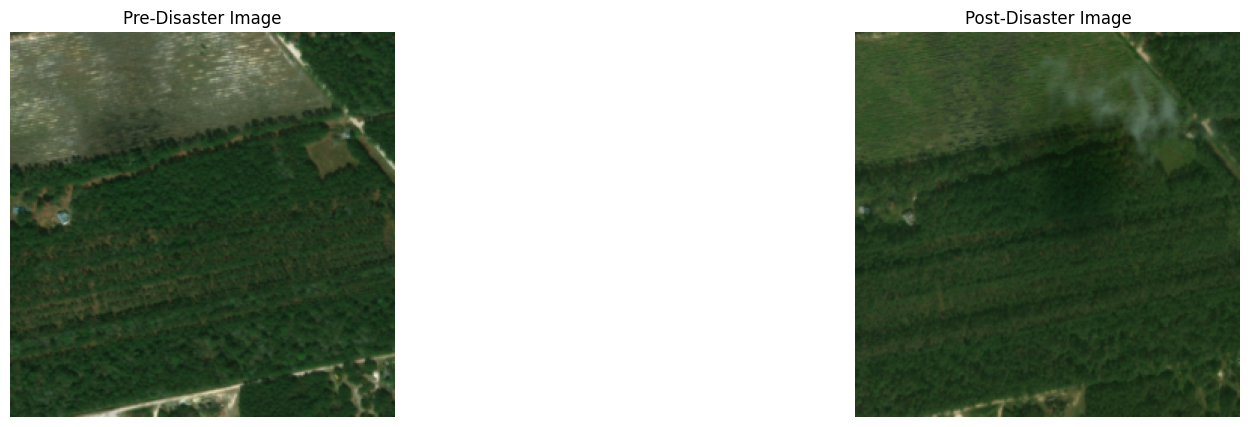

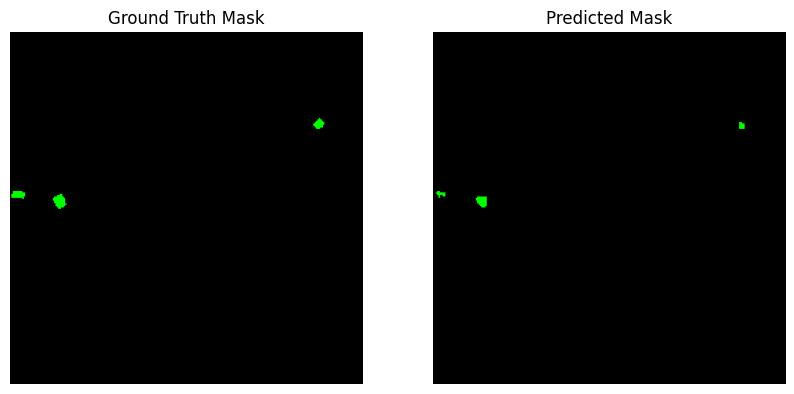


--- Calculating metrics over the entire validation set ---


Evaluating: 100%|██████████| 35/35 [00:49<00:00,  1.42s/it]



--- Model Performance Metric ---
Harmonic Mean F1-Score: 39.03%

--- Detailed Class-wise Metrics ---

Class 'Background':
  - IoU:       96.87%
  - Precision: 98.67%
  - Recall:    98.16%
  - F1-Score:  98.41%

Class 'No-damage':
  - IoU:       57.95%
  - Precision: 67.49%
  - Recall:    80.38%
  - F1-Score:  73.38%

Class 'Minor-damage':
  - IoU:       7.90%
  - Precision: 32.12%
  - Recall:    9.48%
  - F1-Score:  14.64%

Class 'Major damage':
  - IoU:       38.62%
  - Precision: 63.28%
  - Recall:    49.77%
  - F1-Score:  55.72%

Class 'destroyed':
  - IoU:       38.27%
  - Precision: 53.01%
  - Recall:    57.93%
  - F1-Score:  55.36%


In [7]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix
import torch
from tqdm import tqdm

# 1.VISUALIZE A SINGLE PREDICTION (on CPU)
print("--- Visualizing a single sample from the validation set ---")
cpu_device = torch.device('cpu')

# Load the best model to the CPU for visualization
model_for_viz = torch.load(MODEL_SAVE_PATH, map_location=cpu_device, weights_only=False)
model_for_viz.eval()

# Helper functions for visualization
def show_images(images, titles):
    fig, axs = plt.subplots(1, len(images), figsize=(20, 5))
    for i, img in enumerate(images):
        np_img = img.cpu().numpy().transpose((1, 2, 0))
        mean, std = np.array([0.485, 0.456, 0.406]), np.array([0.229, 0.224, 0.225])
        np_img = std * np_img + mean
        np_img = np.clip(np_img, 0, 1)
        axs[i].imshow(np_img)
        axs[i].set_title(titles[i])
        axs[i].axis('off')
    plt.show()

def show_masks(masks, titles, num_classes=5):
    # --- UPDATED COLORS ---
    # black, green, yellow, purple, red
    colors = torch.tensor([
        [0.0, 0.0, 0.0],  # Black
        [0.0, 1.0, 0.0],  # Green
        [1.0, 1.0, 0.0],  # Yellow
        [0.5, 0.0, 0.5],  # Purple
        [1.0, 0.0, 0.0]   # Red
    ], dtype=torch.float32)
    
    fig, axs = plt.subplots(1, len(masks), figsize=(10, 5))
    if len(masks) == 1: axs = [axs]
    for i, mask in enumerate(masks):
        rgb_mask = colors[mask.cpu().long()].permute(2, 0, 1)
        np_mask = rgb_mask.numpy().transpose((1, 2, 0))
        axs[i].imshow(np_mask)
        axs[i].set_title(titles[i])
        axs[i].axis('off')
    plt.show()

# Get one sample and predict
pre_image_viz, post_image_viz, true_mask_viz = val_dataset[0] 
with torch.no_grad():
    _, _, damage_output_viz = model_for_viz(pre_image_viz.unsqueeze(0).to(cpu_device), post_image_viz.unsqueeze(0).to(cpu_device))
    predicted_mask_viz = torch.argmax(damage_output_viz, dim=1)

# Display the visualization
show_images([pre_image_viz, post_image_viz], ["Pre-Disaster Image", "Post-Disaster Image"])
show_masks([true_mask_viz, predicted_mask_viz.squeeze(0)], ["Ground Truth Mask", "Predicted Mask"], num_classes=NUM_CLASSES)


# 2.CALCULATE METRICS OVER THE ENTIRE VALIDATION SET (on GPU)
print("\n--- Calculating metrics over the entire validation set ---")

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device) # Ensure the main model is on the GPU
model.eval()

all_true_masks, all_predicted_masks = [], []
with torch.no_grad():
    for pre_images, post_images, true_masks in tqdm(val_loader, desc="Evaluating"):
        pre_images = pre_images.to(device)
        post_images = post_images.to(device)
        
        _, _, damage_output = model(pre_images, post_images)
        predicted_masks = torch.argmax(damage_output, dim=1)
        
        all_true_masks.extend(true_masks.cpu().numpy().flatten())
        all_predicted_masks.extend(predicted_masks.cpu().numpy().flatten())

# 3.COMPUTE AND DISPLAY THE HARMONIC MEAN F1-SCORE
conf_matrix = confusion_matrix(all_true_masks, all_predicted_masks, labels=range(NUM_CLASSES))
true_positives = np.diag(conf_matrix)
false_positives = np.sum(conf_matrix, axis=0) - true_positives
false_negatives = np.sum(conf_matrix, axis=1) - true_positives

# Calculate Precision, Recall, F1-Score for each class
precision = np.divide(true_positives, (true_positives + false_positives), out=np.zeros_like(true_positives, dtype=float), where=(true_positives + false_positives) != 0)
recall = np.divide(true_positives, (true_positives + false_negatives), out=np.zeros_like(true_positives, dtype=float), where=(true_positives + false_negatives) != 0)
f1_score = np.nan_to_num(2 * (precision * recall) / (precision + recall))

# UPDATED CLASS NAMES
class_names = ["Background", "No-damage", "Minor-damage", "Major damage", "destroyed"]

# UPDATED METRIC CALCULATION (HARMONIC MEAN)
if np.any(f1_score == 0):
    h_mean_f1 = 0.0
else:
    h_mean_f1 = len(f1_score) / np.sum(1.0 / f1_score)

print(f"\n--- Model Performance Metric ---")
print(f"Harmonic Mean F1-Score: {h_mean_f1 * 100:.2f}%")

# Print Detailed Per-Class Metrics (using new names)
print("\n--- Detailed Class-wise Metrics ---")
for i in range(NUM_CLASSES):
    print(f"\nClass '{class_names[i]}':")
    print(f"  - IoU:       {true_positives[i] / (true_positives[i] + false_positives[i] + false_negatives[i]) * 100:.2f}%")
    print(f"  - Precision: {precision[i] * 100:.2f}%")
    print(f"  - Recall:    {recall[i] * 100:.2f}%")
    print(f"  - F1-Score:  {f1_score[i] * 100:.2f}%")